This notebook compares the performance of different ML models with the simulated data.

In [1]:
# Importing all dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
import itertools
from sklearn.manifold import TSNE
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import KMeans

We stick to sklearn library for mojorty of the task. However, we also utilize other libraries such as matplotlib and seaborn for visualization.

Here we start loading the data.
Depending on the number of slices, set N = 20 or 40

Input parameters (emission time, spot size, gun phase and solenoid strength) and all output parameters (z, eps, ksi and d) are combined in one data frame.


If there are NaNs in any column of the data, we delete that row entirely

In [2]:
#change 20 or 40 slices
N = 40 

# Adjust the relative path according to your notebook's location.
folder_path = os.path.abspath(os.path.join("..", "data", "benchmarking"))
data_in_path = os.path.join(folder_path, f"simulation_input_n{N}.csv")
data_out_path = os.path.join(folder_path, f"simulation_output_n{N}.csv")

# Load the CSV files
data_in = pd.read_csv(data_in_path, delimiter=" ")
data_out = pd.read_csv(data_out_path, delimiter=" ")

# Concatenate data_in and data_out along columns
df = pd.concat([data_in, data_out], axis=1)
df = df.dropna()


To ensure uniformity, we normalize the data by dividing each column's values by its maximum, scaling them between 0 and 1.

However, this scales gun_phase from -1 to 1. To shift it to a 0-1 range, we add 1 to each value and divide by 2.

In [3]:
# normalize with max()

df = df/df.max()
df["gun_phase"] = (df["gun_phase"] + 1) / 2
#print(df)

To visualize the predicted system configurations across all emittance values, we compute a weighted average for each parameter (z, eps, ksi), using charge density as the weight. The weights are determined by normalizing the distance-based values (d_i) within each test sample, ensuring a consistent influence of each data point in the final weighted averages.

When calculating the weights, N= number of slices, as defined before.

In [4]:
# Adding columns for outputs with weighted averages

#N = 40  

# Filter columns dynamically based on N
d_values = df.filter(regex='d_.*')
weights_df = pd.DataFrame()

# Calculate weights dynamically for any N
for i in range(1, N + 1):
    weight_col_name = f"W_{i}"
    weights_df[weight_col_name] = d_values[f"d_{i}"] / d_values[[f"d_{i}" for i in range(1, N + 1)]].max(axis=1)

# Calculate weighted averages for z, eps, ksi dynamically
for prefix in ["z", "eps", "ksi"]:
    weighted_sum = sum(df[f"{prefix}_{i}"] * weights_df[f"W_{i}"] for i in range(1, N + 1))
    weight_sum = sum(weights_df[f"W_{i}"] for i in range(1, N + 1))
    
    df[f"weighted_{prefix}"] = weighted_sum / weight_sum
#print(df)

In the next cell, we do a couple of things.

We want all our machine learning models to have same input and target features, so we define them here.

We also ensure that the data thats used for traiing is scaled to avoid the features with larger magnitude influence the learning process.

Then, we split the data into train and test sets. In this case we are doing a 70-30 split, which can be adjusted as per requirement.

we also want to keep track of our predictions, and the errors, so we store them in a dictionary.

In [5]:
input_columns = ["emission_time", "spot_size", "gun_phase", "solenoid_strength"]
target_column = "weighted_eps"

param_grid = {
    'emission_time': np.linspace(0, 1, num=11).tolist(),  
    'spot_size': np.linspace(0, 1, num=11).tolist(),  
    'gun_phase': np.linspace(0, 1, num=11).tolist(),  
    'solenoid_strength': np.linspace(0, 1, num=11).tolist()  
}

data = df.copy()
scaler = StandardScaler()
data[input_columns] = scaler.fit_transform(data[input_columns])
# Prepare features (X) and target (y)
X = data[input_columns]
y = df[target_column]  # Use original target values (unscaled)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

results_dict = {}

At this point, after running all the above cells, we have normalized the data between 0 and 1, calculated a weighted average for output paramters (we use weighted emittance for now). Let try to train the models.

In [6]:
# Instantiate and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Random Forest Regressor trained. Mean Squared Error:", mse)


results_dict["rf"] = {
    'pred_eps': y_pred.tolist(),  # Convert to list if using NumPy arrays
    'weighted_eps': y_test.tolist(),
    'abs_error': np.abs(y_pred - y_test).tolist(),
    'squared_error': ((y_pred - y_test) ** 2).tolist(),
    'mse': mean_squared_error(y_test, y_pred)
}

Random Forest Regressor trained. Mean Squared Error: 0.0002284397917345933


In [7]:
# SVR
svr_model = SVR(kernel='rbf', C=0.9, epsilon=0.2)
svr_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = svr_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("SVR trained. Mean Squared Error:", mse)

results_dict["svr"] = {
    'pred_eps': y_pred.tolist(),  # Convert to list if using NumPy arrays
    'weighted_eps': y_test.tolist(),
    'abs_error': np.abs(y_pred - y_test).tolist(),
    'squared_error': ((y_pred - y_test) ** 2).tolist(),
    'mse': mean_squared_error(y_test, y_pred)
}

SVR trained. Mean Squared Error: 0.013830454563217616


In [8]:
# XGB
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
xgb_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("XGB trained. Mean Squared Error:", mse)

results_dict["xgb"] = {
    'pred_eps': y_pred.tolist(),  # Convert to list if using NumPy arrays
    'weighted_eps': y_test.tolist(),
    'abs_error': np.abs(y_pred - y_test).tolist(),
    'squared_error': ((y_pred - y_test) ** 2).tolist(),
    'mse': mean_squared_error(y_test, y_pred)
}

XGB trained. Mean Squared Error: 0.0007146396312735338


In [9]:
# Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
gbr_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = gbr_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("gradient boosting regressor trained. Mean Squared Error:", mse)

results_dict["gbr"] = {
    'pred_eps': y_pred.tolist(),  # Convert to list if using NumPy arrays
    'weighted_eps': y_test.tolist(),
    'abs_error': np.abs(y_pred - y_test).tolist(),
    'squared_error': ((y_pred - y_test) ** 2).tolist(),
    'mse': mean_squared_error(y_test, y_pred)
}

gradient boosting regressor trained. Mean Squared Error: 0.0007409441527661332


In [10]:
# Polynomial Regressor degree 2
p2_model = Pipeline([
            ('poly', PolynomialFeatures(degree=2)),
            ('scaler', StandardScaler()),
            ('regressor', LinearRegression())
        ])
p2_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = p2_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Polynomial regressor with degree 2 trained. Mean Squared Error:", mse)

results_dict["p2"] = {
    'pred_eps': y_pred.tolist(),  # Convert to list if using NumPy arrays
    'weighted_eps': y_test.tolist(),
    'abs_error': np.abs(y_pred - y_test).tolist(),
    'squared_error': ((y_pred - y_test) ** 2).tolist(),
    'mse': mean_squared_error(y_test, y_pred)
}

Polynomial regressor with degree 2 trained. Mean Squared Error: 0.005079359995526429


In [11]:
# Polynomial Regressor degree 3
p3_model = Pipeline([
            ('poly', PolynomialFeatures(degree=3)),
            ('scaler', StandardScaler()),
            ('regressor', LinearRegression())
        ])
p3_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = p3_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Polynomial regressor with degree 3 trained. Mean Squared Error:", mse)

results_dict["p3"] = {
    'pred_eps': y_pred.tolist(),  # Convert to list if using NumPy arrays
    'weighted_eps': y_test.tolist(),
    'abs_error': np.abs(y_pred - y_test).tolist(),
    'squared_error': ((y_pred - y_test) ** 2).tolist(),
    'mse': mean_squared_error(y_test, y_pred)
}

Polynomial regressor with degree 3 trained. Mean Squared Error: 0.004806841077652802


In [12]:
# Polynomial Regressor degree 4
p4_model = Pipeline([
            ('poly', PolynomialFeatures(degree=4)),
            ('scaler', StandardScaler()),
            ('regressor', LinearRegression())
        ])
p4_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = p4_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Polynomial regressor with degree 4 trained. Mean Squared Error:", mse)

results_dict["p4"] = {
    'pred_eps': y_pred.tolist(),  # Convert to list if using NumPy arrays
    'weighted_eps': y_test.tolist(),
    'abs_error': np.abs(y_pred - y_test).tolist(),
    'squared_error': ((y_pred - y_test) ** 2).tolist(),
    'mse': mean_squared_error(y_test, y_pred)
}

Polynomial regressor with degree 4 trained. Mean Squared Error: 0.004668171818252206


In [13]:
# Polynomial Regressor degree 5
p5_model = Pipeline([
            ('poly', PolynomialFeatures(degree=5)),
            ('scaler', StandardScaler()),
            ('regressor', LinearRegression())
        ])
p5_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = p5_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Polynomial regressor with degree 5 trained. Mean Squared Error:", mse)

results_dict["p5"] = {
    'pred_eps': y_pred.tolist(),  # Convert to list if using NumPy arrays
    'weighted_eps': y_test.tolist(),
    'abs_error': np.abs(y_pred - y_test).tolist(),
    'squared_error': ((y_pred - y_test) ** 2).tolist(),
    'mse': mean_squared_error(y_test, y_pred)
}

Polynomial regressor with degree 5 trained. Mean Squared Error: 0.003981023600022292


In [14]:
# Ridge
ridge_model = Pipeline([
            ('scaler', StandardScaler()),
            ('ridge', Ridge(alpha=1.0))
        ])
ridge_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = ridge_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Ridge regression model trained. Mean Squared Error:", mse)

results_dict["ridge"] = {
    'pred_eps': y_pred.tolist(),  # Convert to list if using NumPy arrays
    'weighted_eps': y_test.tolist(),
    'abs_error': np.abs(y_pred - y_test).tolist(),
    'squared_error': ((y_pred - y_test) ** 2).tolist(),
    'mse': mean_squared_error(y_test, y_pred)
}

Ridge regression model trained. Mean Squared Error: 0.005585920177139323


In [15]:
# Lasso
lasso_model = Pipeline([
            ('scaler', StandardScaler()),
            ('lasso', Lasso(alpha=0.01))
        ])
lasso_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = lasso_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Lasso regression model trained. Mean Squared Error:", mse)

results_dict["lasso"] = {
    'pred_eps': y_pred.tolist(),  # Convert to list if using NumPy arrays
    'weighted_eps': y_test.tolist(),
    'abs_error': np.abs(y_pred - y_test).tolist(),
    'squared_error': ((y_pred - y_test) ** 2).tolist(),
    'mse': mean_squared_error(y_test, y_pred)
}

Lasso regression model trained. Mean Squared Error: 0.005770583284182542


In [16]:
# ElasticNet
elastic_model = Pipeline([
            ('scaler', StandardScaler()),
            ('elasticnet', ElasticNet(alpha=0.01, l1_ratio=0.5))
        ])
elastic_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = elastic_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("EalsticNet regression model trained. Mean Squared Error:", mse)

results_dict["elastic"] = {
    'pred_eps': y_pred.tolist(),  # Convert to list if using NumPy arrays
    'weighted_eps': y_test.tolist(),
    'abs_error': np.abs(y_pred - y_test).tolist(),
    'squared_error': ((y_pred - y_test) ** 2).tolist(),
    'mse': mean_squared_error(y_test, y_pred)
}

EalsticNet regression model trained. Mean Squared Error: 0.005637405026888836


In [17]:
# Train MLP Regressor

mlp_model = Pipeline([
            ('scaler', StandardScaler()),  # Ensure features are scaled
            ('mlp', MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', learning_rate_init=0.001, max_iter=500, random_state=42))
        ])

mlp_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = mlp_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("multilayer Perceptron regressor trained. Mean Squared Error:", mse)

results_dict["mlp"] = {
    'pred_eps': y_pred.tolist(),  # Convert to list if using NumPy arrays
    'weighted_eps': y_test.tolist(),
    'abs_error': np.abs(y_pred - y_test).tolist(),
    'squared_error': ((y_pred - y_test) ** 2).tolist(),
    'mse': mean_squared_error(y_test, y_pred)
}

multilayer Perceptron regressor trained. Mean Squared Error: 0.00045218102576805367


After training all the models, and storing the predictions and error values, lets visualize them.

Here is a violin plot to see the absolute errors between the predictions and true values of emittances

Outliers sometimes make it difficult to visualize the results. For easy visualization, we eliminate the outliers, by only considering the data that lies within 2 standard deviations form the mean.

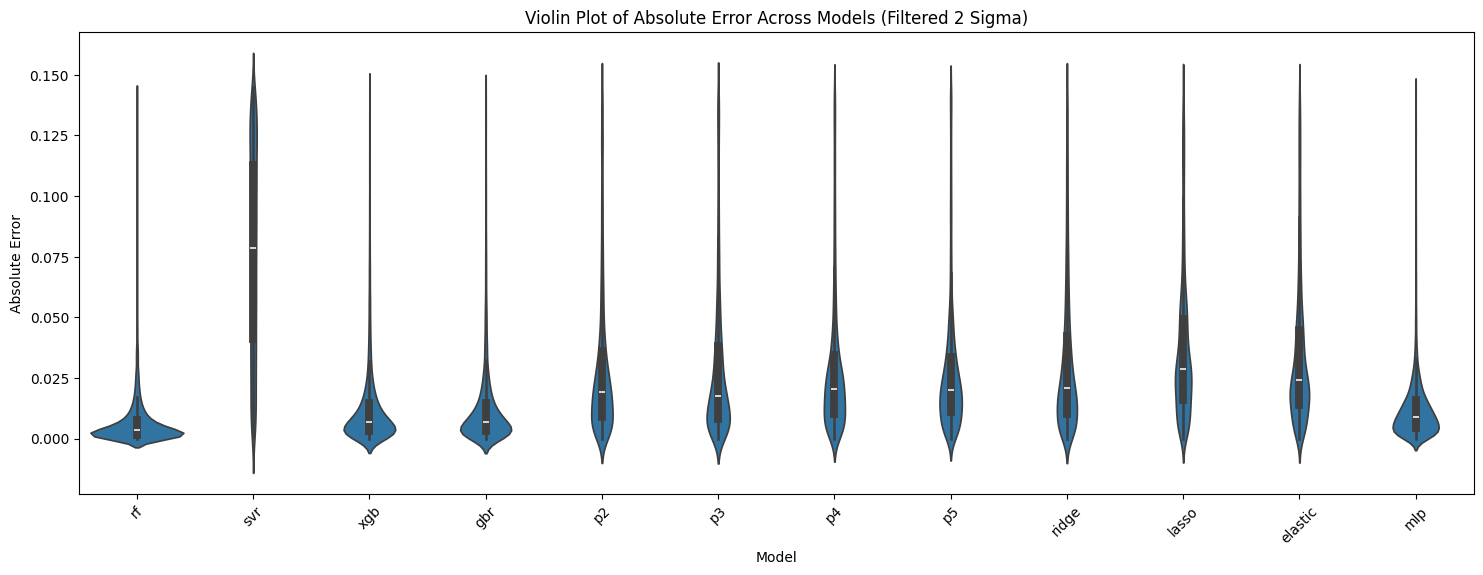

In [18]:
# Build the combined DataFrame from your dictionary
data_list = []
for model_name, result in results_dict.items():
    temp_df = pd.DataFrame({"Model": model_name, "abs_error": result["abs_error"]})
    data_list.append(temp_df)
    
plot_df = pd.concat(data_list, ignore_index=True)

# Calculate overall mean and standard deviation for abs_error
mean_error = plot_df["abs_error"].mean()
std_error = plot_df["abs_error"].std()

# Filter out values outside ±2 sigma
lower_bound = mean_error - 2* std_error
upper_bound = mean_error + 2* std_error

filtered_plot_df = plot_df[(plot_df["abs_error"] >= lower_bound) & (plot_df["abs_error"] <= upper_bound)]

# Create the violin plot with filtered data
plt.figure(figsize=(18, 6))
sns.violinplot(x="Model", y="abs_error", data=filtered_plot_df, inner="box")

plt.xticks(rotation=45)
plt.xlabel("Model")
plt.ylabel("Absolute Error")
plt.title("Violin Plot of Absolute Error Across Models (Filtered 2 Sigma)")
plt.show()


Next, let do T-SNE plot, to get a 2D visualization of the emittance with all input configurations. We will observe the ground truth first, followed by the prediction plots for each model.

Here we compute the TSNE transormation, reducing 4 dimensions to 2.

In [19]:
# Feature matrix for t-SNE from your input features
X = X_test[["emission_time", "spot_size", "gun_phase", "solenoid_strength"]]

# Perform t-SNE transformation
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X)

# Convert to DataFrame
tsne_df = pd.DataFrame(X_embedded, columns=["TSNE-1", "TSNE-2"])

In [ ]:
For plotting, we need to find the correct model names as keys from the dictionary. Let's also save the titels for the plot in plot_names.

In [20]:
# Define model names and corresponding plot names
model_names = ["rf", "svr", "xgb", "gbr", "p2", "p3", "p4", "p5", "ridge", "lasso", "elastic", "mlp"]
plot_names = ["Random Forest", "SVM", "XGB", "Gradient Boosting", 
              "Polynomial N=2", "Polynomial N=3", "Polynomial N=4", "Polynomial N=5", 
              "Ridge", "Lasso", "ElasticNet", "MLP"]

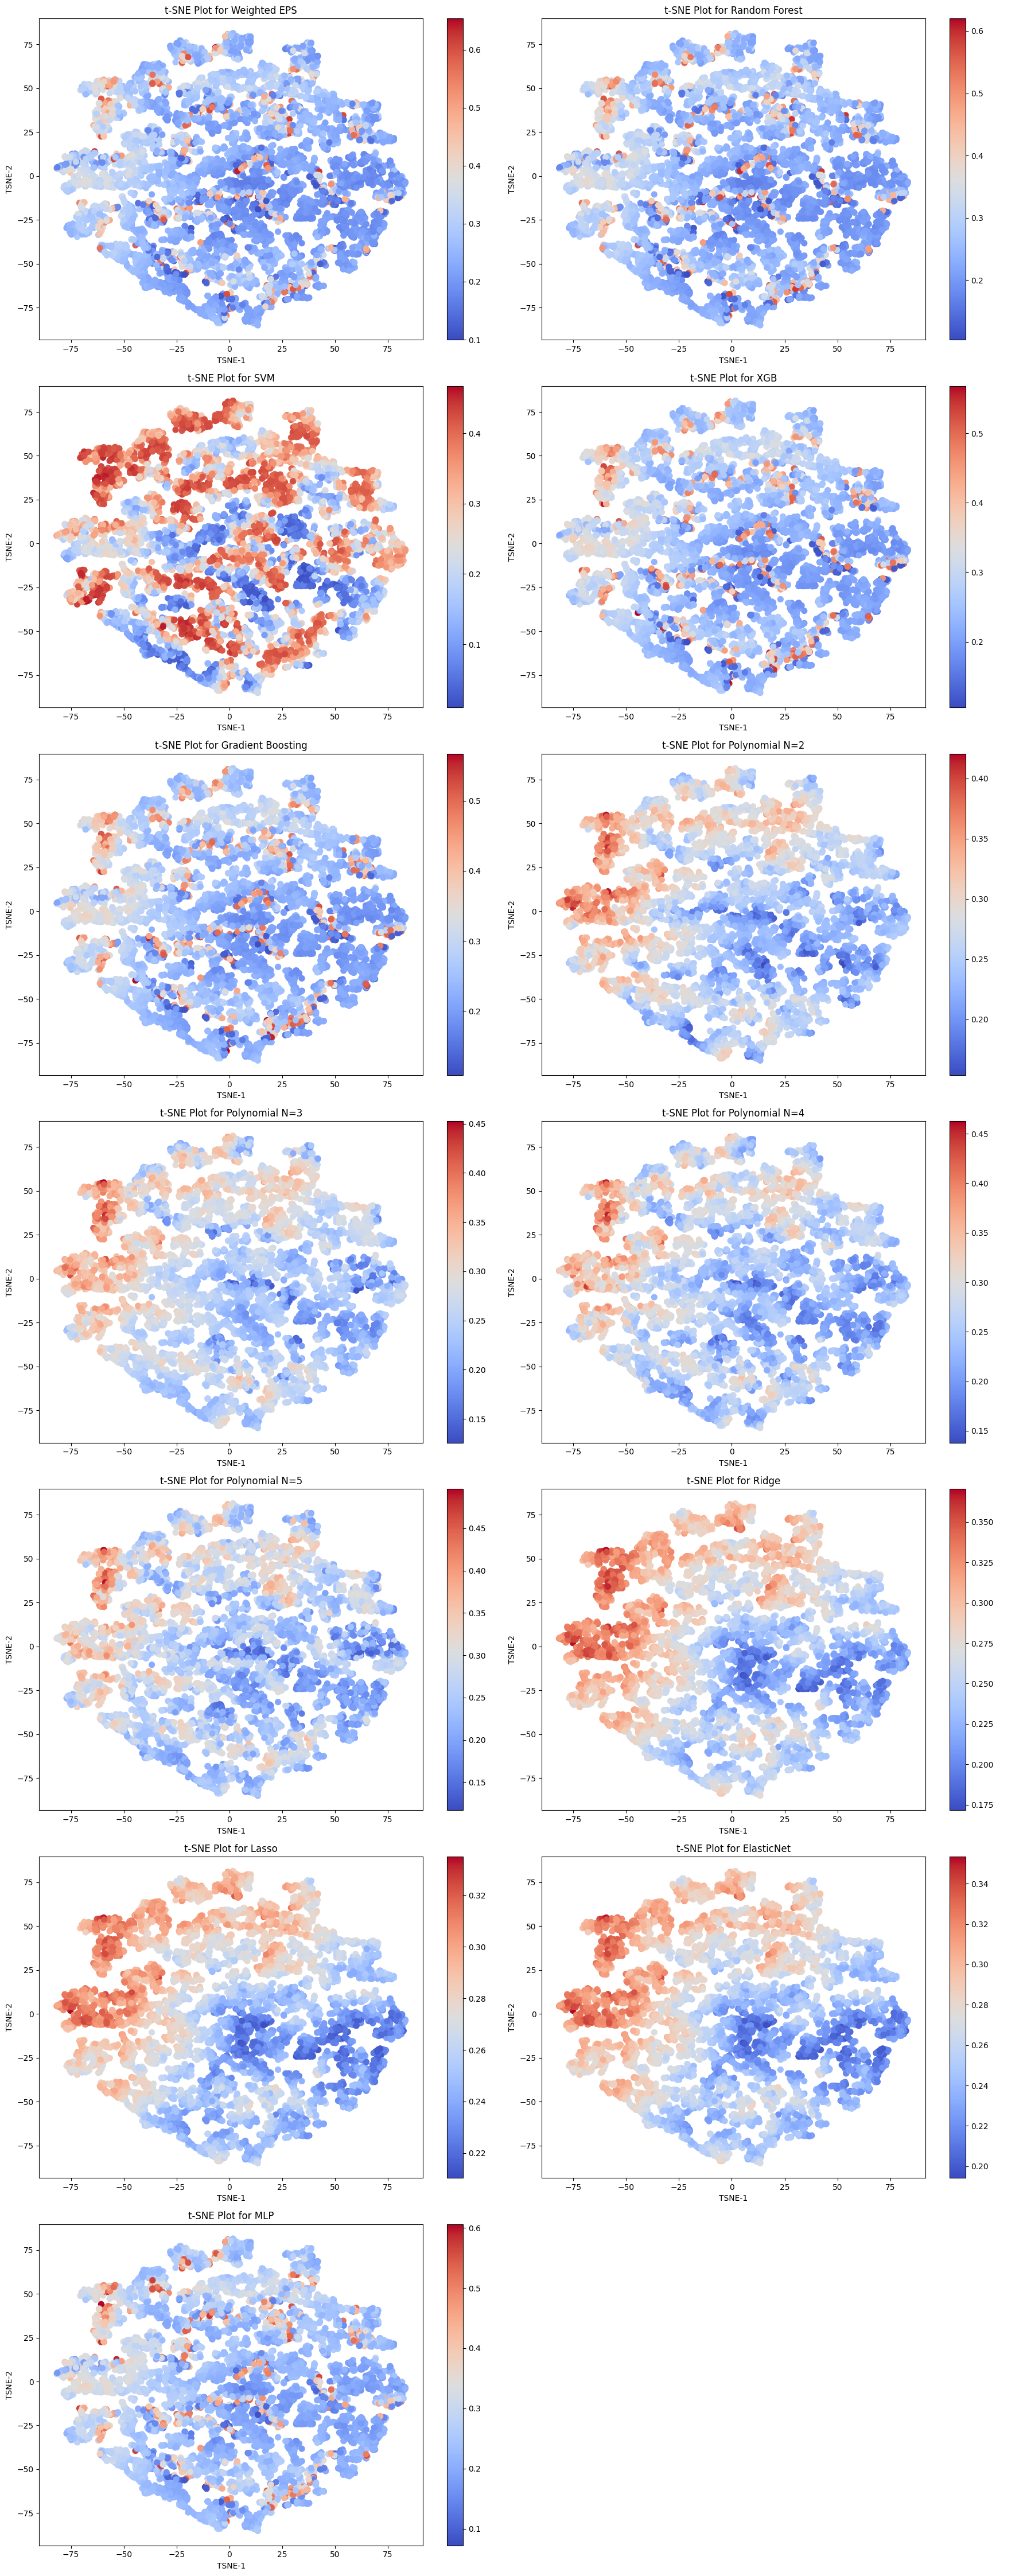

In [21]:
# Set up subplots: here we create a grid with enough subplots to display each model
fig, axes = plt.subplots(7, 2, figsize=(18, 45))
axes = axes.flatten()

# Plot the weighted emittance as the first plot
ax0 = axes[0]
weighted_eps = results_dict[model_names[0]]["weighted_eps"]
scatter = ax0.scatter(
    tsne_df["TSNE-1"], 
    tsne_df["TSNE-2"], 
    c=weighted_eps, 
    cmap="coolwarm", 
    s=50
)
ax0.set_title("t-SNE Plot for Weighted EPS")
ax0.set_xlabel("TSNE-1")
ax0.set_ylabel("TSNE-2")
plt.colorbar(scatter, ax=ax0 )


# Loop through each model and plot its prediction data using t-SNE embedding
for i, model in enumerate(model_names):
    if i+1 >= len(axes):  # Safety check in case there are extra subplots
        break
    
    # Retrieve the prediction list from your dictionary
    pred_eps = results_dict[model]["pred_eps"]
    
    scatter = axes[i+1].scatter(
        tsne_df["TSNE-1"], 
        tsne_df["TSNE-2"], 
        c=pred_eps, 
        cmap="coolwarm", 
        s=50
    )
    axes[i+1].set_title(f"t-SNE Plot for {plot_names[i]}")
    axes[i+1].set_xlabel("TSNE-1")
    axes[i+1].set_ylabel("TSNE-2")
    plt.colorbar(scatter, ax=axes[i+1])

    # Hide unused subplots
for j in range(i + 2, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Here we see the four input parameters in two dimensions, and the colour representing points with high emittance. Red represents higher emittance values, while blue represents lower emittance values.

On first glance, some models are significantly worse at their performance. SVR, polynomial degree 2 and 3, Ridge, Lasso and ElasticNet are not performing well.

Random Forest, gradient boosting, extreme gradient boosting and Multilayer perceptron are very close to the true weighted emittance values in their predictions.

Polynomial regression of degree 4 and 5 are also closer in their estimaton of emittance than other models.